In [17]:
import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

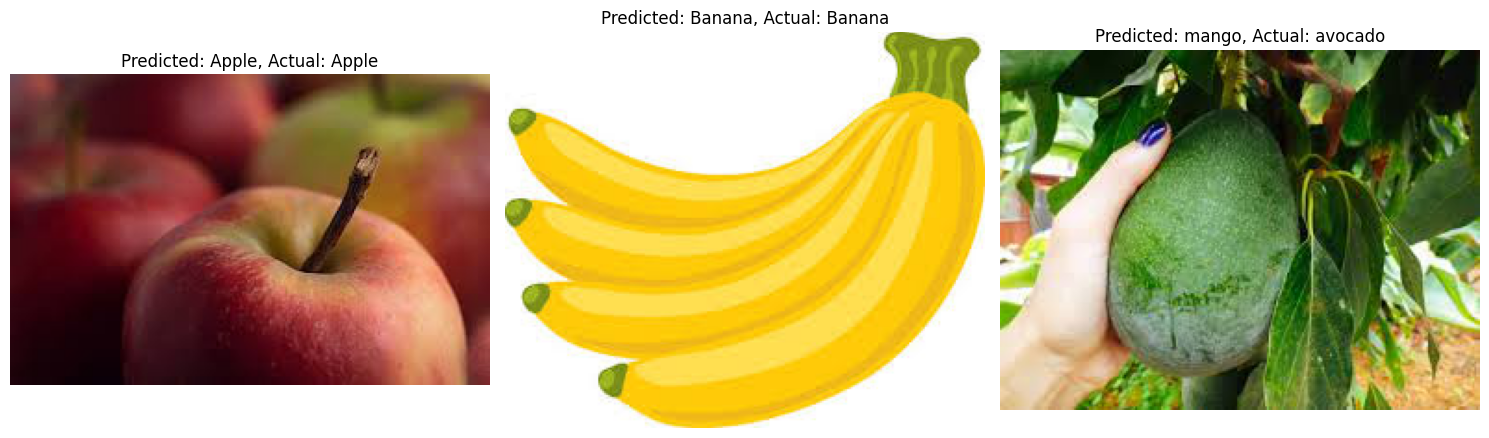

In [18]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import clip

# CLIP 모델 및 전처리 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 데이터 경로 설정
data_path = "/home/user/sb/4th_Project/MY_data/train"  # 실제 데이터 경로로 수정하세요.

# 서브카테고리(클래스) 및 이미지 경로 불러오기
subcategories = sorted(os.listdir(data_path))
images = {sub: [os.path.join(data_path, sub, img) for img in os.listdir(os.path.join(data_path, sub))] for sub in subcategories}

# 이미지 인덱스 선택 (임의로 3개 선택)
selected_images = [images[sub][1] for sub in subcategories[:3]]  # 각 카테고리에서 첫 번째 이미지를 선택

# 텍스트 입력 전처리
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

# 플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 이미지 처리 및 시각화
for i, image_path in enumerate(selected_images):
    # 이미지 열기 및 전처리
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)

    # 이미지와 텍스트 특징 계산
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # 특징 정규화
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # 이미지와 텍스트 특징 유사도 계산
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # 플롯에 이미지 표시
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}, Actual: {os.path.basename(os.path.dirname(image_path))}")
    axes[i].axis('off')

# 플롯 표시
plt.tight_layout()
plt.show()


In [19]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Define the custom dataset class
class FruitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []  # List to hold image file paths
        self.labels = []  # List to hold labels (subcategories)

        # List all subdirectories and their images
        for subcategory in os.listdir(root_dir):
            sub_dir = os.path.join(root_dir, subcategory)
            if os.path.isdir(sub_dir):  # Check if it's a directory
                for image_name in os.listdir(sub_dir):
                    image_path = os.path.join(sub_dir, image_name)
                    if image_path.endswith(('jpg', 'jpeg', 'png')):  # Filter image files
                        self.image_paths.append(image_path)
                        self.labels.append(subcategory)

        # Create a sorted list of subcategories to map labels to indices
        self.subcategories = sorted(set(self.labels))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Convert to RGB if necessary
        label = self.labels[idx]

        # Find the label index
        label_index = self.subcategories.index(label)

        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)

        return image, label_index

# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create the dataset using the provided path to the train directory
dataset = FruitDataset(root_dir='/home/user/sb/4th_Project/MY_data/train', transform=transform)  # Replace with the actual path to your dataset

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Optionally create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [20]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)


In [21]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)


In [22]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)


In [23]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
            
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned_Vit.pth')  # Save the model's state dictionary


Epoch 1/10, Loss: 0.0411:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2666: 100%|██████████| 58/58 [00:03<00:00, 16.43it/s]


Epoch [1/10], Loss: 2.2666
Validation Accuracy: 37.960954446854664%


Epoch 2/10, Loss: 2.0583: 100%|██████████| 58/58 [00:03<00:00, 16.78it/s]


Epoch [2/10], Loss: 2.0583
Validation Accuracy: 70.93275488069415%


Epoch 3/10, Loss: 1.8698: 100%|██████████| 58/58 [00:03<00:00, 16.97it/s]


Epoch [3/10], Loss: 1.8698
Validation Accuracy: 85.24945770065077%


Epoch 4/10, Loss: 1.6974: 100%|██████████| 58/58 [00:03<00:00, 17.01it/s]


Epoch [4/10], Loss: 1.6974
Validation Accuracy: 89.3709327548807%


Epoch 5/10, Loss: 1.5396: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


Epoch [5/10], Loss: 1.5396
Validation Accuracy: 91.1062906724512%


Epoch 6/10, Loss: 1.3968: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


Epoch [6/10], Loss: 1.3968
Validation Accuracy: 91.75704989154013%


Epoch 7/10, Loss: 1.2698: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


Epoch [7/10], Loss: 1.2698
Validation Accuracy: 92.19088937093275%


Epoch 8/10, Loss: 1.1545: 100%|██████████| 58/58 [00:03<00:00, 16.91it/s]


Epoch [8/10], Loss: 1.1545
Validation Accuracy: 92.84164859002169%


Epoch 9/10, Loss: 1.0523: 100%|██████████| 58/58 [00:03<00:00, 16.92it/s]


Epoch [9/10], Loss: 1.0523
Validation Accuracy: 94.14316702819957%


Epoch 10/10, Loss: 0.9621: 100%|██████████| 58/58 [00:03<00:00, 16.91it/s]


Epoch [10/10], Loss: 0.9621
Validation Accuracy: 94.57700650759219%


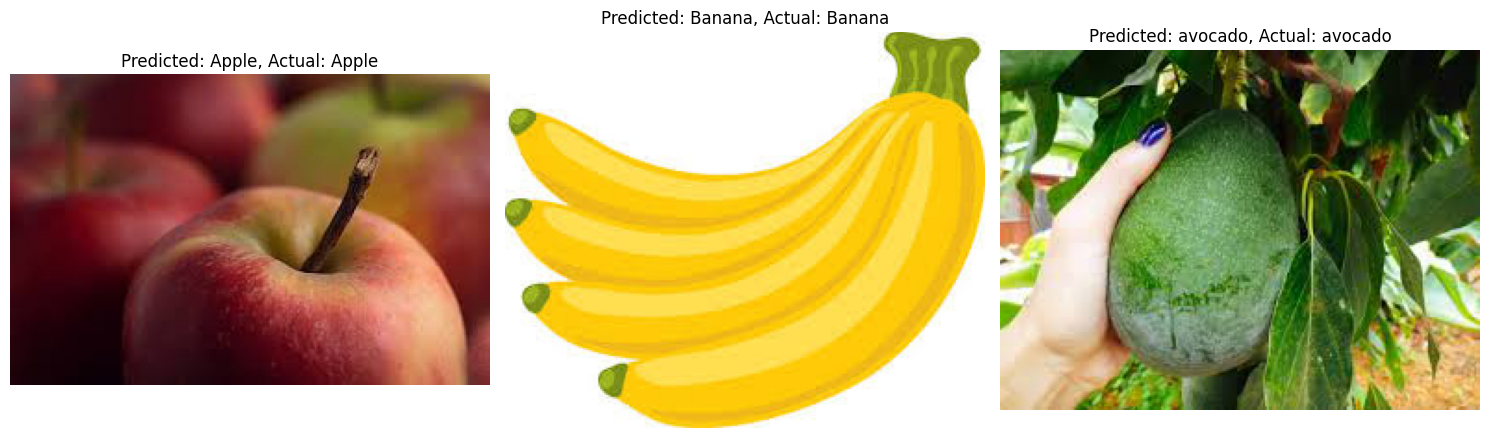

In [24]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import os
import clip

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned_Vit.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

subcategories = sorted(os.listdir(data_path))
images = {sub: [os.path.join(data_path, sub, img) for img in os.listdir(os.path.join(data_path, sub))] for sub in subcategories}

# 이미지 인덱스 선택 (임의로 3개 선택)
selected_images = [images[sub][1] for sub in subcategories[:3]]  # 각 카테고리에서 첫 번째 이미지를 선택

# 텍스트 입력 전처리
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

# 플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 이미지 처리 및 시각화
for i, image_path in enumerate(selected_images):
    # 이미지 열기 및 전처리
    image = Image.open(image_path)
    
    # 실제 레이블 설정 (이미지 경로에서 서브카테고리 추출)
    true_label = os.path.basename(os.path.dirname(image_path))

    image_input = transform(image).unsqueeze(0).to(device)

    # 이미지와 텍스트 특징 계산
    with torch.no_grad():
        output = model_ft(image_input)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # 플롯에 이미지 표시
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {predicted_label}, Actual: {true_label}")
    axes[i].axis('off')

# 플롯 표시
plt.tight_layout()
plt.show()
